## Imports

In [ ]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree
from google.colab import drive
drive.mount('/content/drive')


import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [ ]:
pcp_df = pd.read_csv("/content/drive/MyDrive/colab/power_consumption_prediction.csv")
cl_df = pd.read_csv("/content/drive/MyDrive/colab/CLdata.csv")
bs_df = pd.read_csv("/content/drive/MyDrive/colab/BSinfo.csv")
ec_df  = pd.read_csv("/content/drive/MyDrive/colab/ECdata.csv")
ss_df = pd.read_csv("/content/drive/MyDrive/colab/SampleSubmission.csv")

pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape

((26705, 4), (125575, 10), (1217, 8), (92629, 3), (26139, 2))

In [ ]:
ec_df.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [ ]:
cl_df.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
bs_df.head()

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


from matplotlib import pyplot as plt
_df_0['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('BS').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('RUType').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Bandwidth']
  ys = series['Frequency']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Bandwidth', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BS')):
  _plot_series(series, series_name, i)
  fig.legend(title='BS', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Bandwidth')
_ = plt.ylabel('Frequency')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Bandwidth']
  ys = series['Frequency']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Bandwidth', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('RUType')):
  _plot_series(series, series_name, i)
  fig.legend(title='RUType', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Bandwidth')
_ = plt.ylabel('Frequency')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Bandwidth']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Bandwidth'}, axis=1)
              .sort_values('Bandwidth', ascending=True))
  xs = counted['Bandwidth']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('Bandwidth', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('BS')):
  _plot_series(series, series_name, i)
  fig.legend(title='BS', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Bandwidth')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Bandwidth']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Bandwidth'}, axis=1)
              .sort_values('Bandwidth', ascending=True))
  xs = counted['Bandwidth']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('Bandwidth', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('RUType')):
  _plot_series(series, series_name, i)
  fig.legend(title='RUType', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Bandwidth')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_7['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['RUType'].value_counts()
    for x_label, grp in _df_8.groupby('BS')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('BS')
_ = plt.ylabel('RUType')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_9['BS'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_9, x='Frequency', y='BS', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_10['RUType'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_10, x='Frequency', y='RUType', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
pcp_df.head()

,Time,BS,Energy,w
0,1/1/2023 6:00,B_0,NaN,1
1,1/1/2023 11:00,B_0,NaN,1
2,1/1/2023 12:00,B_0,NaN,1
3,1/1/2023 13:00,B_0,NaN,1
4,1/1/2023 23:00,B_0,NaN,1


from matplotlib import pyplot as plt
import seaborn as sns
_df_11.groupby('Time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Time'}, axis=1)
              .sort_values('Time', ascending=True))
  xs = counted['Time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Time')):
  _plot_series(series, series_name, i)
  fig.legend(title='Time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['w']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'w'}, axis=1)
              .sort_values('w', ascending=True))
  xs = counted['w']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('w', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Time')):
  _plot_series(series, series_name, i)
  fig.legend(title='Time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('w')
_ = plt.ylabel('count()')

In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=pcp_df)

https://docs.google.com/spreadsheets/d/1SDHWlR4fVnjZMgD7nvhrbTZz0kACwPBprAfsbNVJGSw#gid=0


In [ ]:
pcp_df['w'].value_counts()

,count
w,
1,23755
5,2950


## Data Pre-Processing

In [ ]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [ ]:
pcp_df = rename_columns(pcp_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

In [ ]:
cl_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


from matplotlib import pyplot as plt
_df_14['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15['load'].plot(kind='hist', bins=20, title='load')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_16.groupby('time').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_17.plot(kind='scatter', x='index', y='load', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['load']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_18.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('time')):
  _plot_series(series, series_name, i)
  fig.legend(title='time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('load')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_19.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('time')):
  _plot_series(series, series_name, i)
  fig.legend(title='time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time']
  ys = series['load']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_20.sort_values('time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('time')):
  _plot_series(series, series_name, i)
  fig.legend(title='time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('load')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'time'}, axis=1)
              .sort_values('time', ascending=True))
  xs = counted['time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_21.sort_values('time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('time')):
  _plot_series(series, series_name, i)
  fig.legend(title='time', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_22['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_23['load'].plot(kind='line', figsize=(8, 4), title='load')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_24['time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_24, x='index', y='time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_25['time'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_25, x='load', y='time', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
bs_df.head()

,bs,cellname,rutype,mode,frequency,bandwidth,antennas,txpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [ ]:
ec_df.head()

,time,bs,energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [ ]:
pcp_df.head()

,time,bs,energy,w
0,1/1/2023 6:00,B_0,NaN,1
1,1/1/2023 11:00,B_0,NaN,1
2,1/1/2023 12:00,B_0,NaN,1
3,1/1/2023 13:00,B_0,NaN,1
4,1/1/2023 23:00,B_0,NaN,1


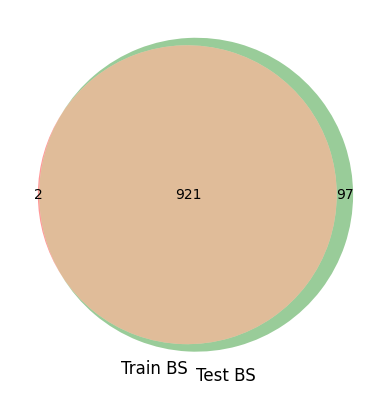

In [ ]:
train_bs_set = set(ec_df['bs'].values.tolist())
test_bs_set = set(pcp_df['bs'].values.tolist())

venn2([train_bs_set, test_bs_set], ('Train BS', 'Test BS'))
plt.show()

In [ ]:
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

In [ ]:
cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')
cl_bs_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934


In [ ]:
cl_bs_df[cl_bs_df['bs'] == 'B_0']

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118787,2023-01-02 19:00:00,B_0,Cell1,0.206135,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118788,2023-01-02 20:00:00,B_0,Cell1,0.152981,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118789,2023-01-02 21:00:00,B_0,Cell1,0.150808,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118790,2023-01-02 22:00:00,B_0,Cell1,0.289731,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504


In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique()

,cellname
bs,
B_0,2
B_1,1
B_10,2
B_100,1
B_1000,1
...,...
B_995,1
B_996,1
B_997,1


In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

,count
cellname,
1,827
2,191
4,2


In [ ]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [ ]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(bs_df.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')

In [ ]:
cl_bs_df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2


In [ ]:
cl_bs_df.describe()

,time,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3
count,118768,118768.000000,6711.000000,48.000000,48.000000,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.0,6711.0,48.0,48.0,118768.000000,6711.0,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,4.800000e+01,4.800000e+01,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.000000,48.000000
mean,2023-01-03 23:54:54.281287680,0.246362,0.111214,0.070212,0.081115,0.042145,0.004985,0.0,0.0,0.038640,0.003311,0.0,0.0,0.000082,0.000135,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.0,0.0,0.019168,0.386253,0.0,0.0,373.152776,379.542459,4.269800e+02,4.269800e+02,16.323740,6.338251,2.0,2.0,2.493079,2.218149,2.0,2.0,6.728786,7.028953,6.877429,6.877429
min,2023-01-01 01:00:00,0.000000,0.008190,0.045942,0.045904,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,155.600000,155.600000,4.269800e+02,4.269800e+02,2.000000,2.000000,2.0,2.0,1.000000,1.000000,2.0,2.0,5.381166,6.427504,6.877429,6.877429
25%,2023-01-02 10:00:00,0.055714,0.051894,0.054442,0.051822,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,189.000000,365.000000,4.269800e+02,4.269800e+02,10.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.427504,6.761584,6.877429,6.877429
50%,2023-01-03 19:00:00,0.162470,0.079423,0.066760,0.067856,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.275973,0.0,0.0,365.000000,426.980000,4.269800e+02,4.269800e+02,20.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
75%,2023-01-05 13:00:00,0.367142,0.138202,0.079385,0.095495,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.803992,0.0,0.0,532.000000,426.980000,4.269800e+02,4.269800e+02,20.000000,10.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
max,2023-01-08 00:00:00,0.993957,0.891770,0.174846,0.196519,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.154563,0.062805,0.0,0.0,0.0,0.0,0.0,0.0,0.768070,0.0,0.0,0.0,0.931032,0.927924,0.0,0.0,979.998000,697.002000,4.269800e+02,4.269800e+02,20.000000,20.000000,2.0,2.0,64.000000,8.000000,2.0,2.0,8.375336,7.877728,6.877429,6.877429
std,NaN,0.239354,0.091569,0.023807,0.038373,0.194184,0.064911,0.0,0.0,0.186785,0.052831,0.0,0.0,0.002439,0.002422,0.0,0.0,0.0,0.0,0.0,0.0,0.002882,0.0,0.0,0.0,0.112214,0.395205,0.0,0.0,145.409519,102.348829,2.872248e-13,2.872248e-13,5.238965,6.209317,0.0,0.0,4.617650,0.755766,0.0,0.0,0.330830,0.386024,0.000000,0.000000


In [ ]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [ ]:
df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')

In [ ]:
df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,64.275037
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,18.086697
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,30.343797
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,NaN
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,15.545590


In [ ]:
df['energy'].isna().value_counts()

,count
energy,
False,92629
True,26139


In [ ]:
df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

In [ ]:
ss_df.shape

(26139, 2)

In [ ]:
ec_df.shape

(92629, 3)

## EDA

In [ ]:
df['energy'].describe()

,energy
count,92629.000000
mean,28.138997
std,13.934645
min,0.747384
25%,18.236173
50%,24.065770
75%,35.724963
max,100.000000


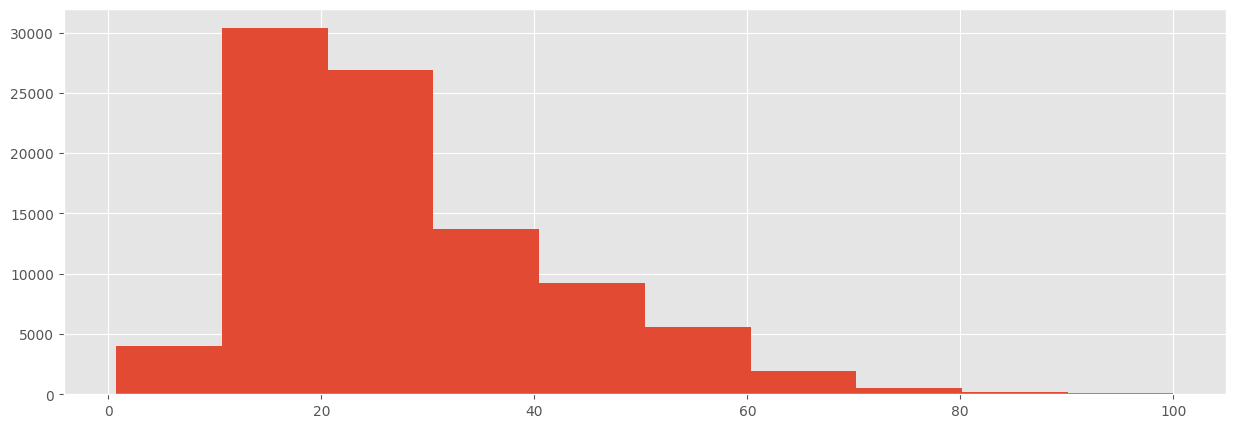

In [ ]:
plt.figure(figsize=(15, 5))
df['energy'].hist()
plt.show()

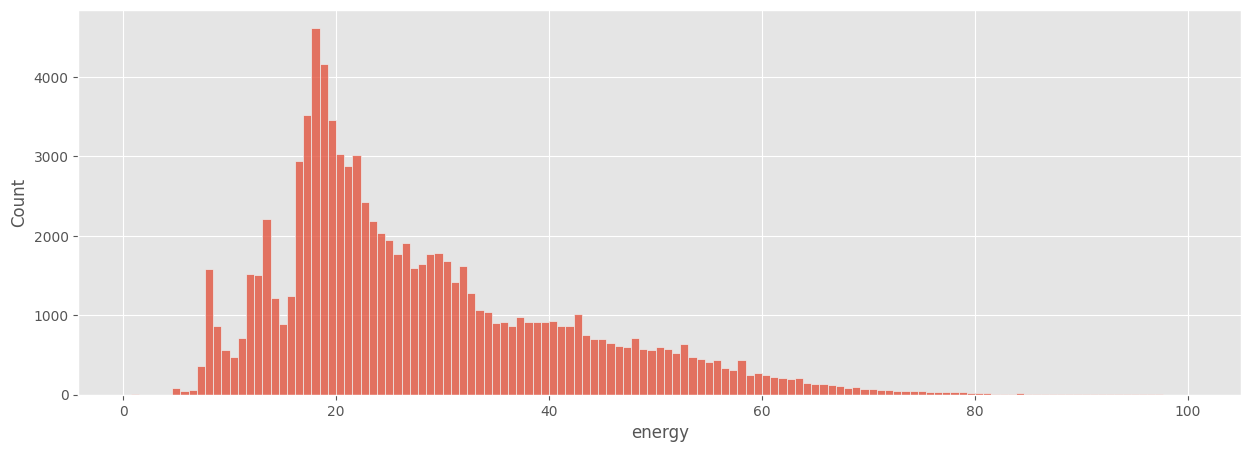

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(df['energy'])
plt.show()

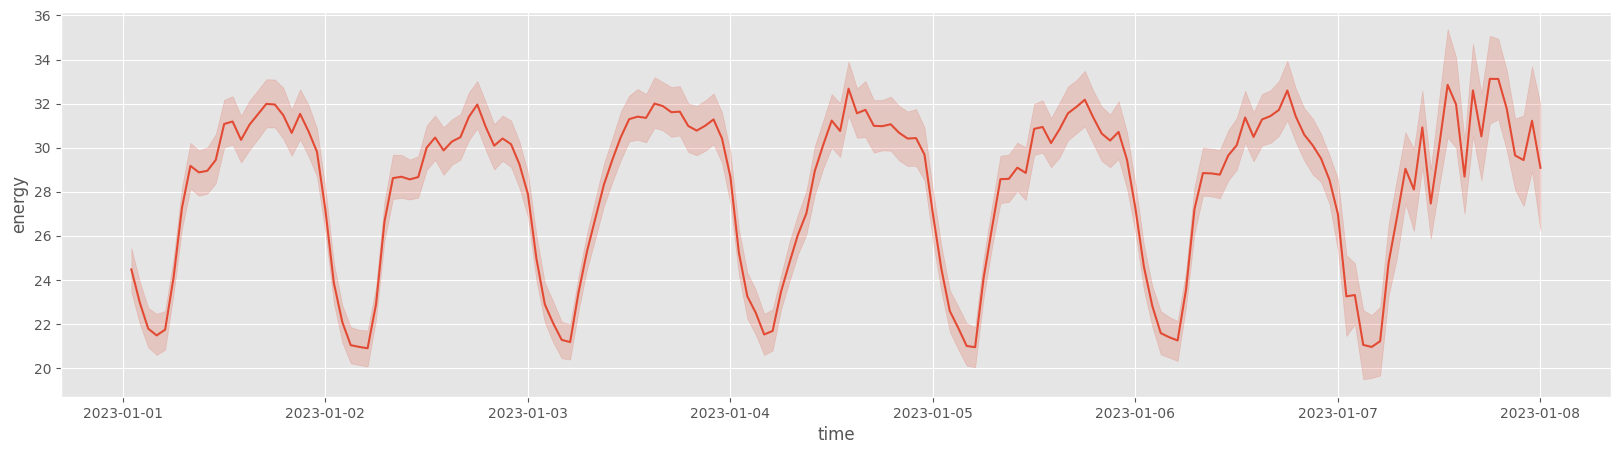

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy')
plt.show()

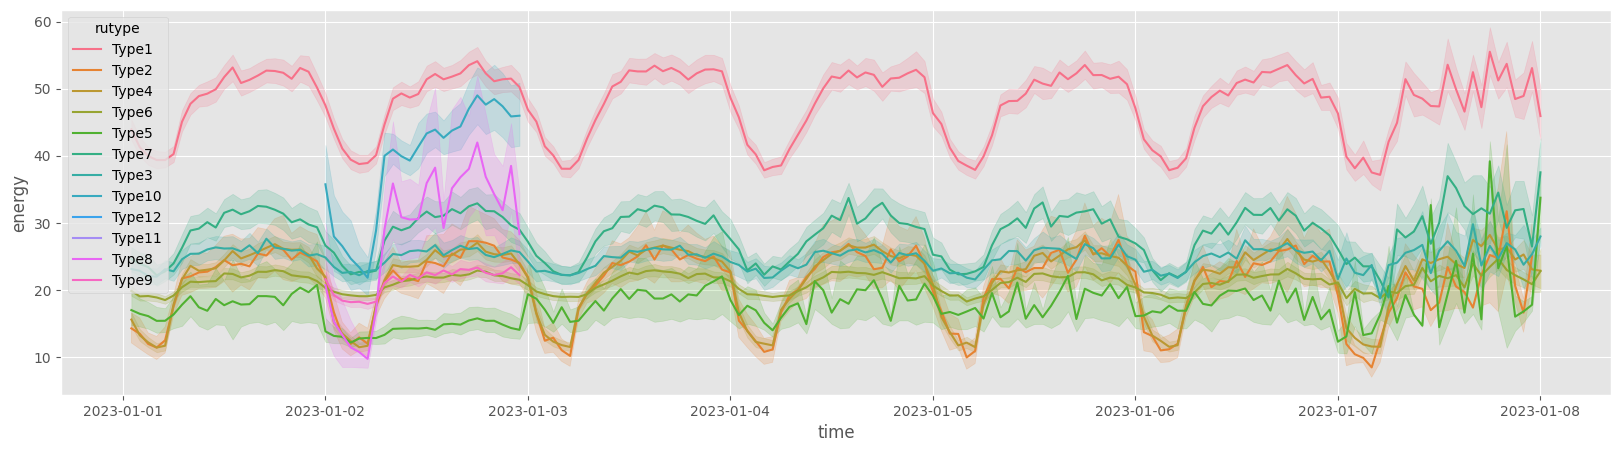

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='rutype')
plt.show()

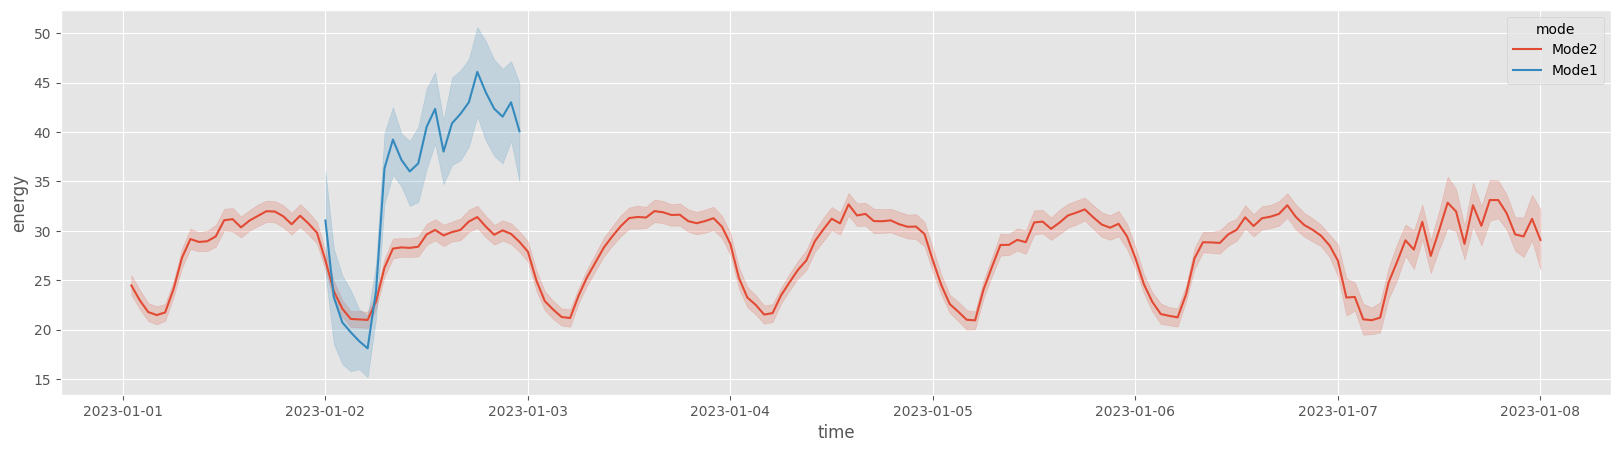

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='mode')
plt.show()

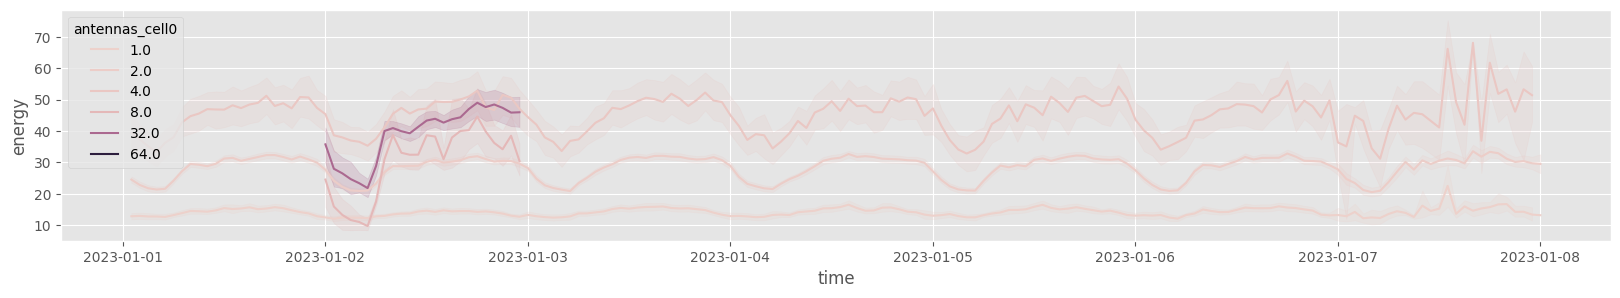

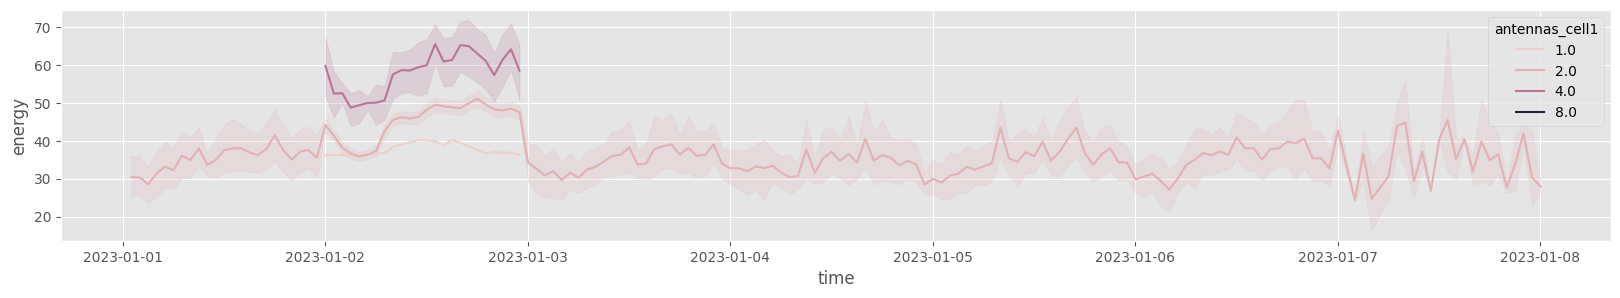

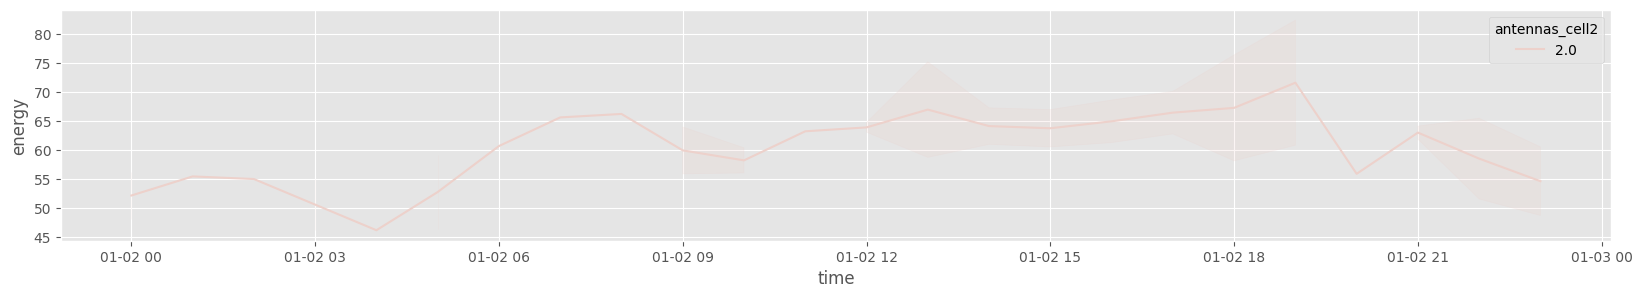

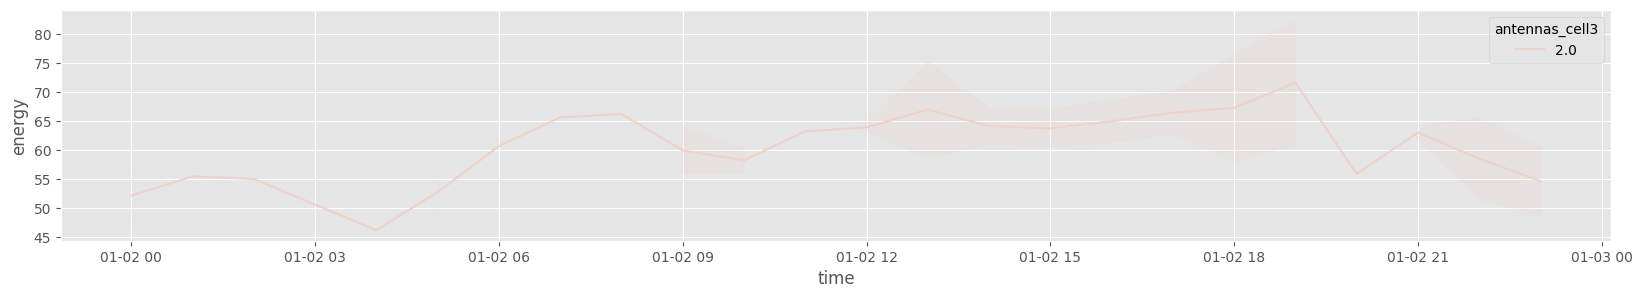

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell3')
plt.show()

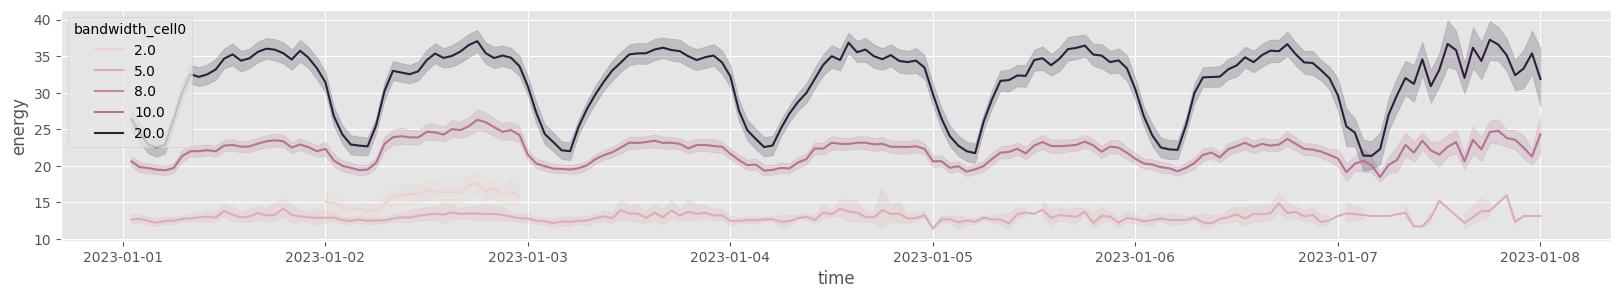

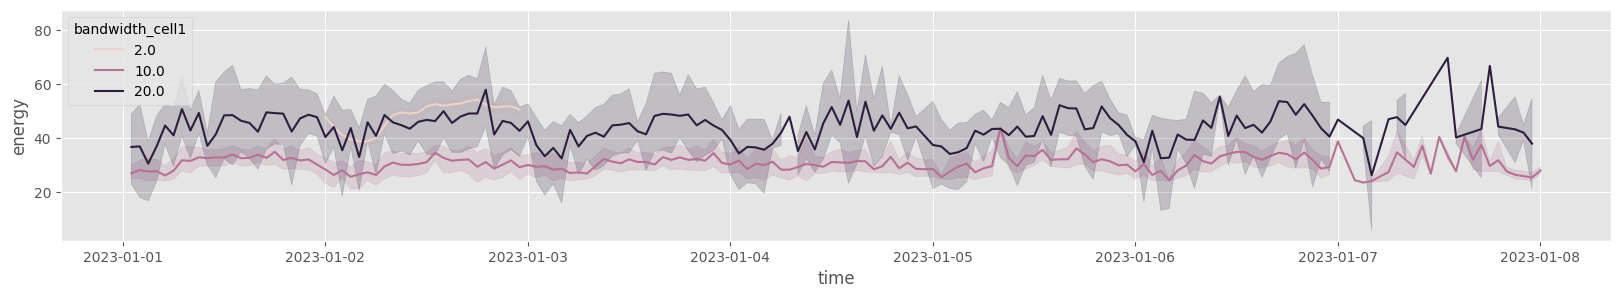

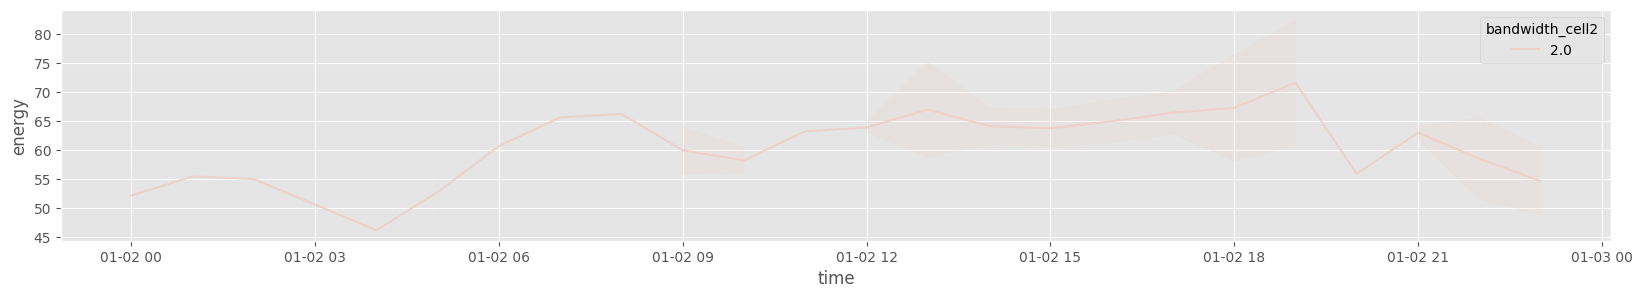

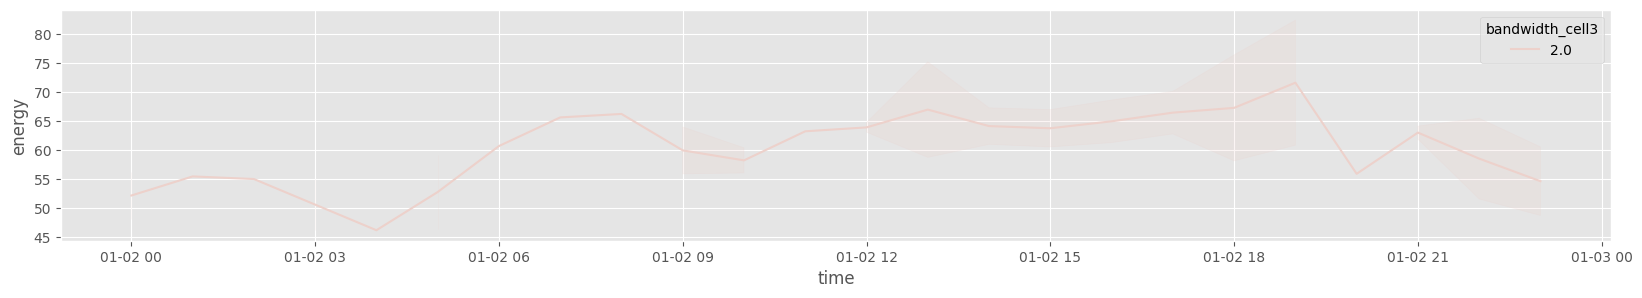

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell3')
plt.show()

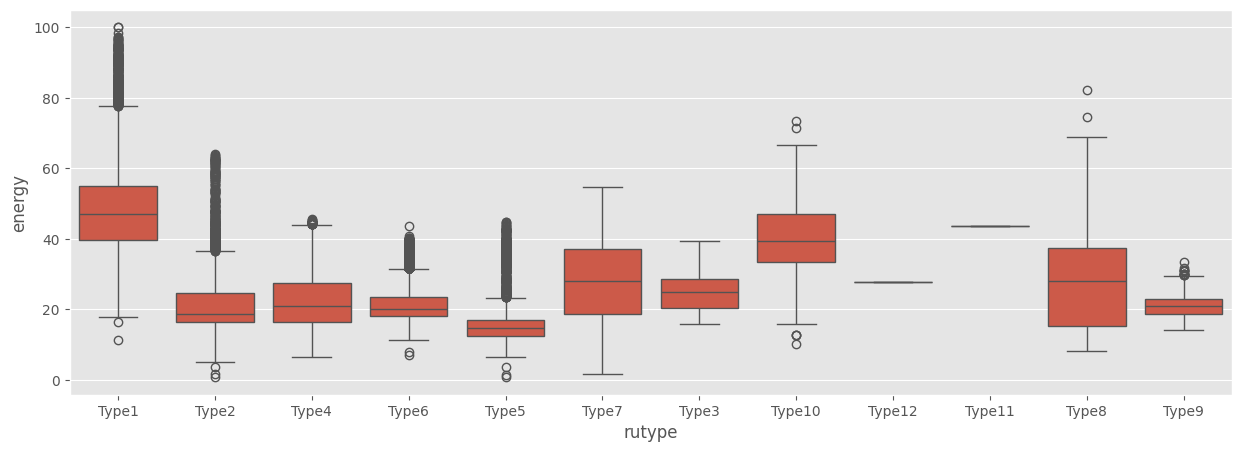

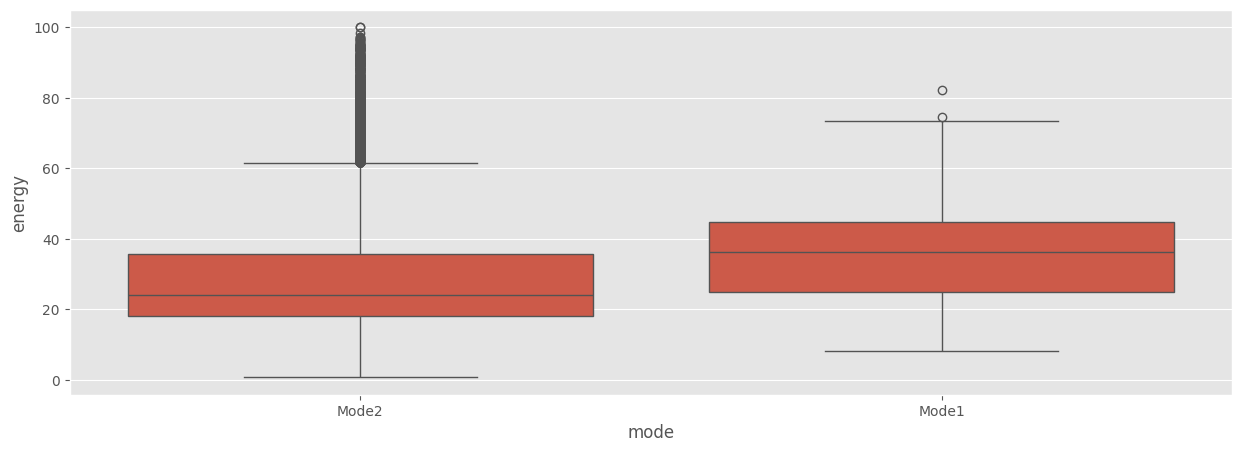

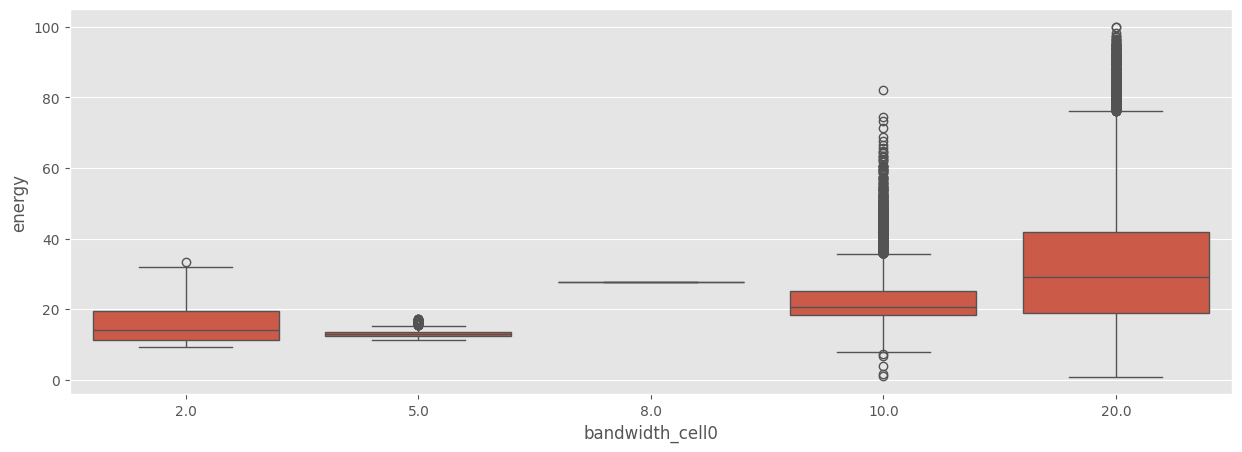

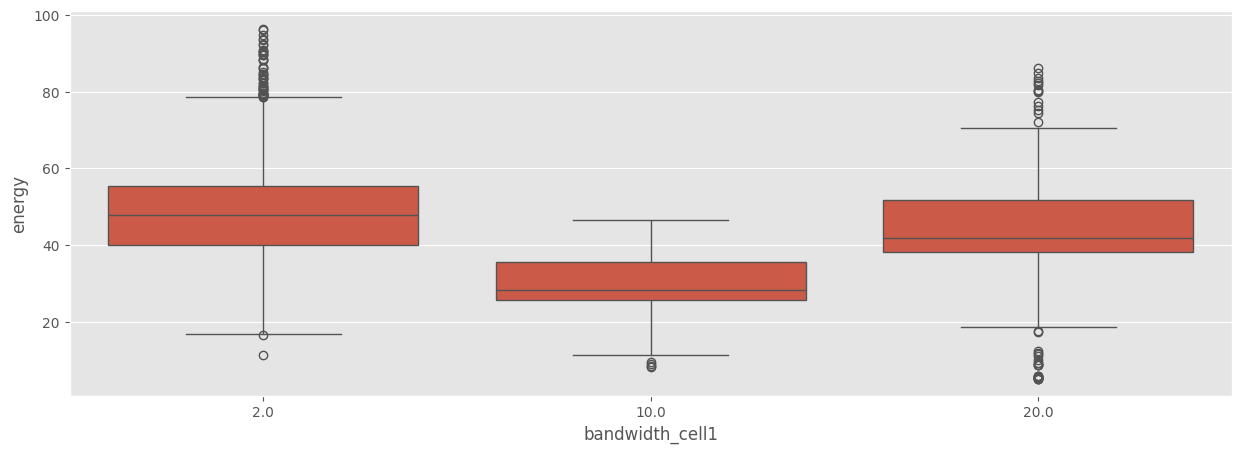

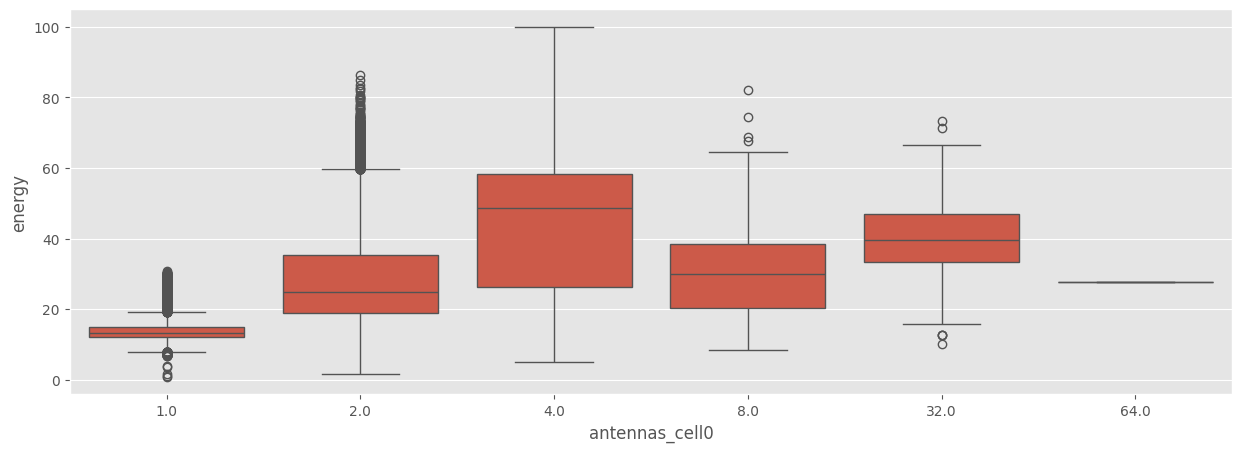

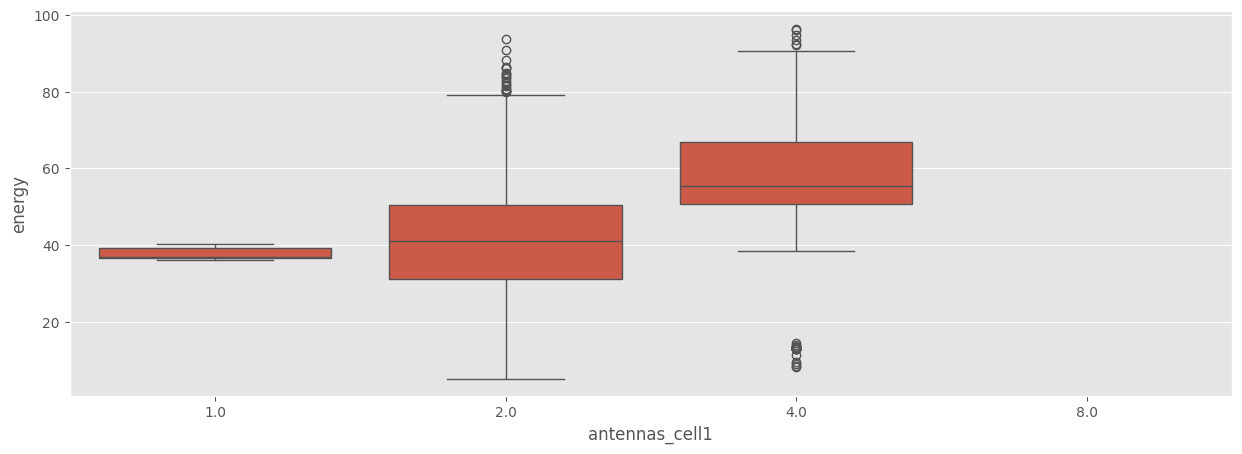

In [ ]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df, x=fe, y='energy')
    plt.show()

In [ ]:
def plot_cat_train_test_dist(df, fe_name, hue='split'):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the distribution plot on the first subplot
    sns.countplot(data=df[df['split'] == 'train'], ax=axes[0], x=fe_name)
    axes[0].set_title('Train Count Plot')

    # Plot the box plot on the second subplot
    sns.countplot(data=df[df['split'] == 'test'], ax=axes[1], x=fe_name)
    axes[1].set_title('Test Count Plot')

    sns.countplot(data=df, ax=axes[2], x=fe_name, hue='split')
    axes[2].set_title('Train & Test Count Plot')

    plt.show()

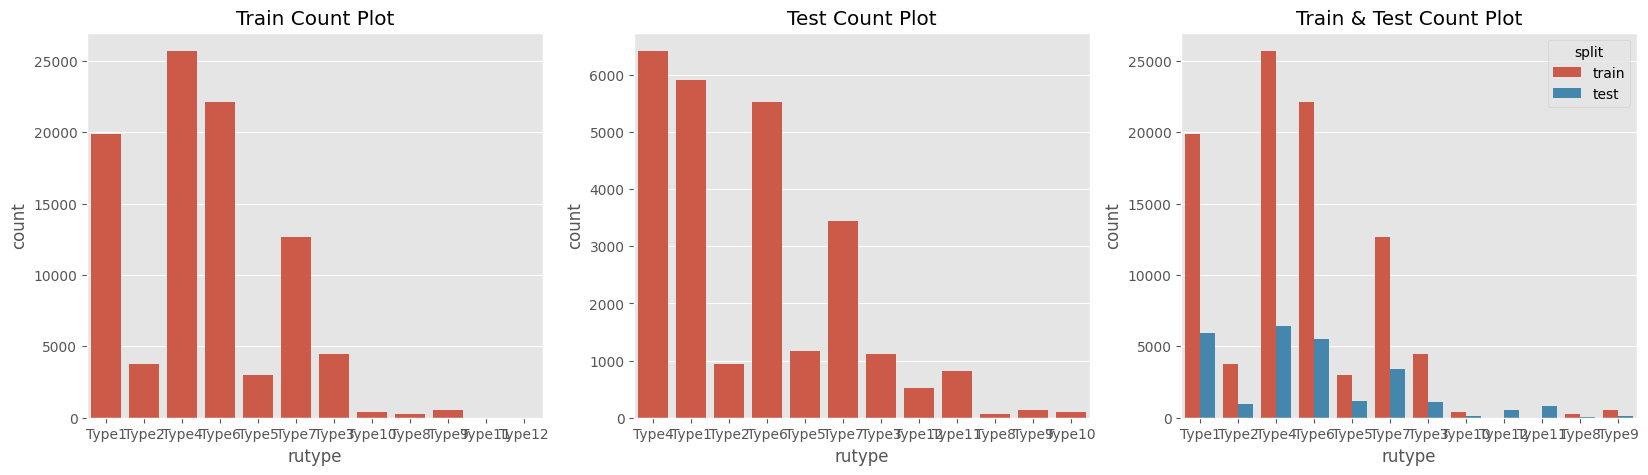

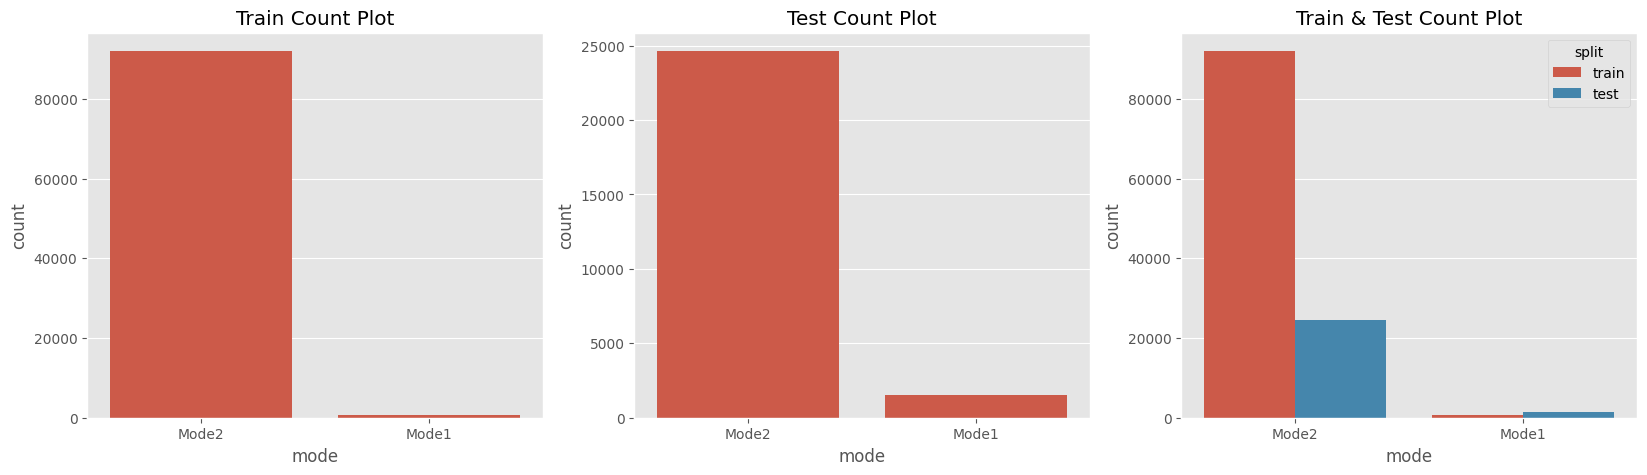

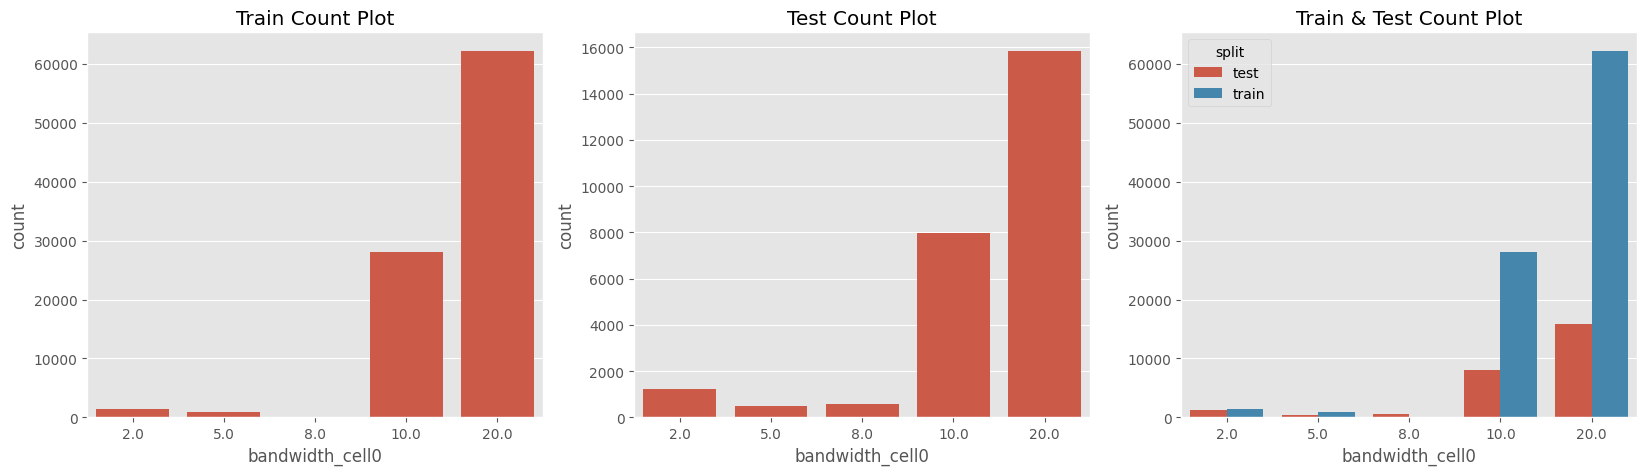

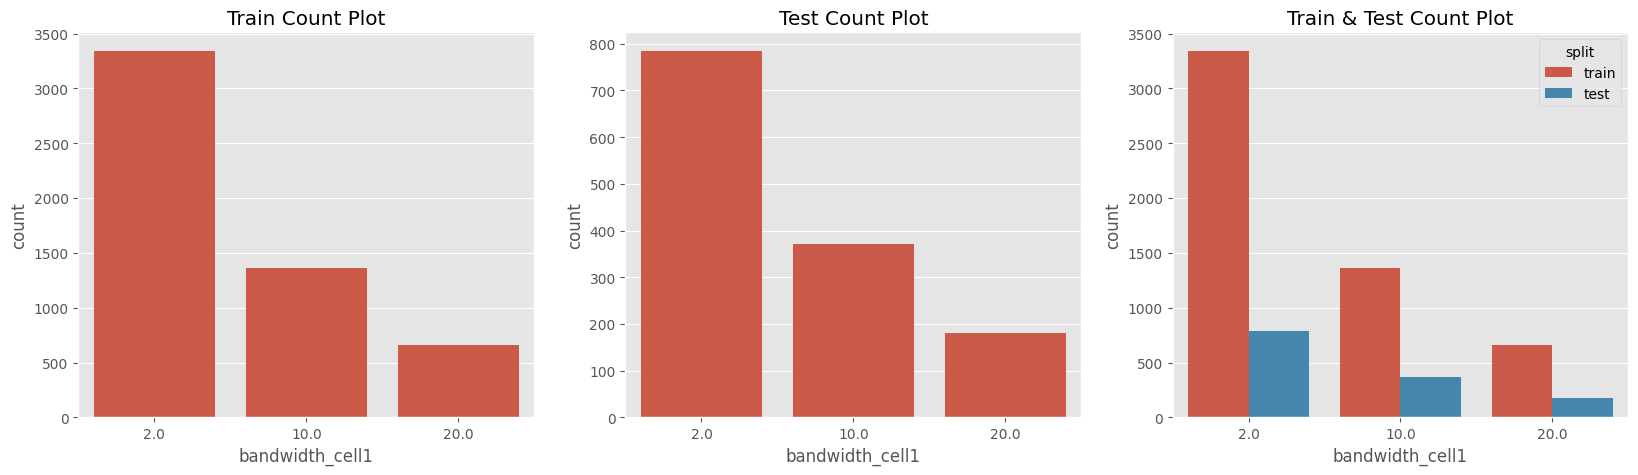

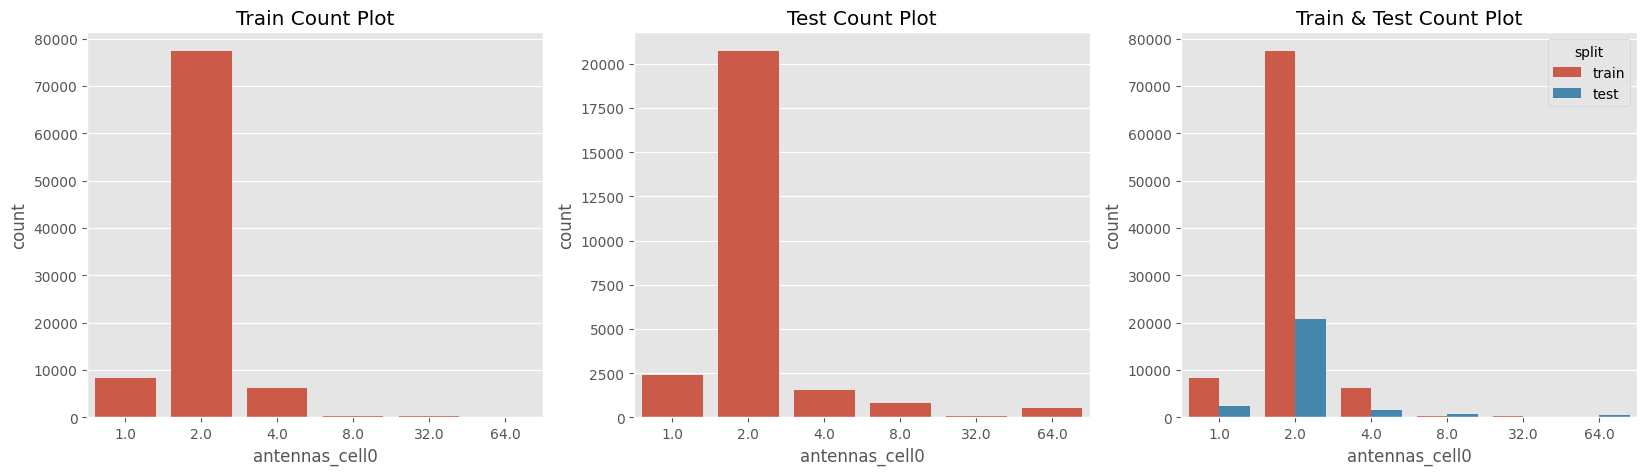

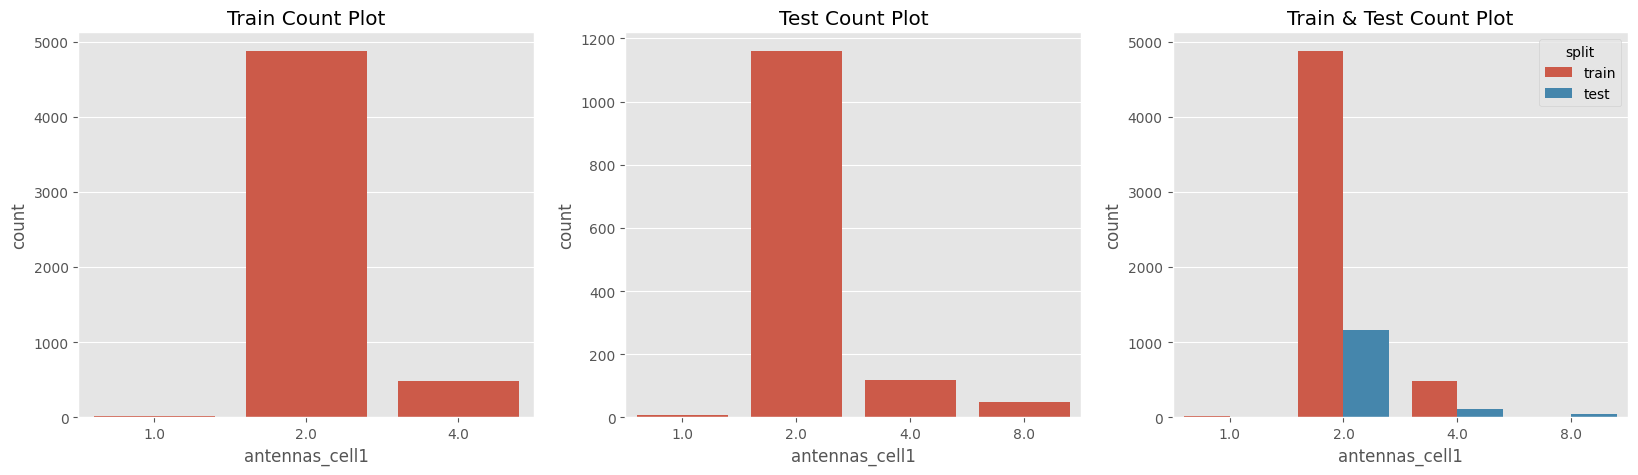

In [ ]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plot_cat_train_test_dist(df=df, fe_name=fe, hue='split')

In [ ]:
df.groupby("split")['rutype'].value_counts().sort_index()

split  rutype
test   Type1      5908
       Type10      101
       Type11      815
       Type12      527
       Type2       939
       Type3      1111
       Type4      6419
       Type5      1164
       Type6      5521
       Type7      3446
       Type8        58
       Type9       130
train  Type1     19902
       Type10      403
       Type11        1
       Type12        1
       Type2      3757
       Type3      4442
       Type4     25677
       Type5      2974
       Type6     22083
       Type7     12641
       Type8       230
       Type9       518
Name: count, dtype: int64

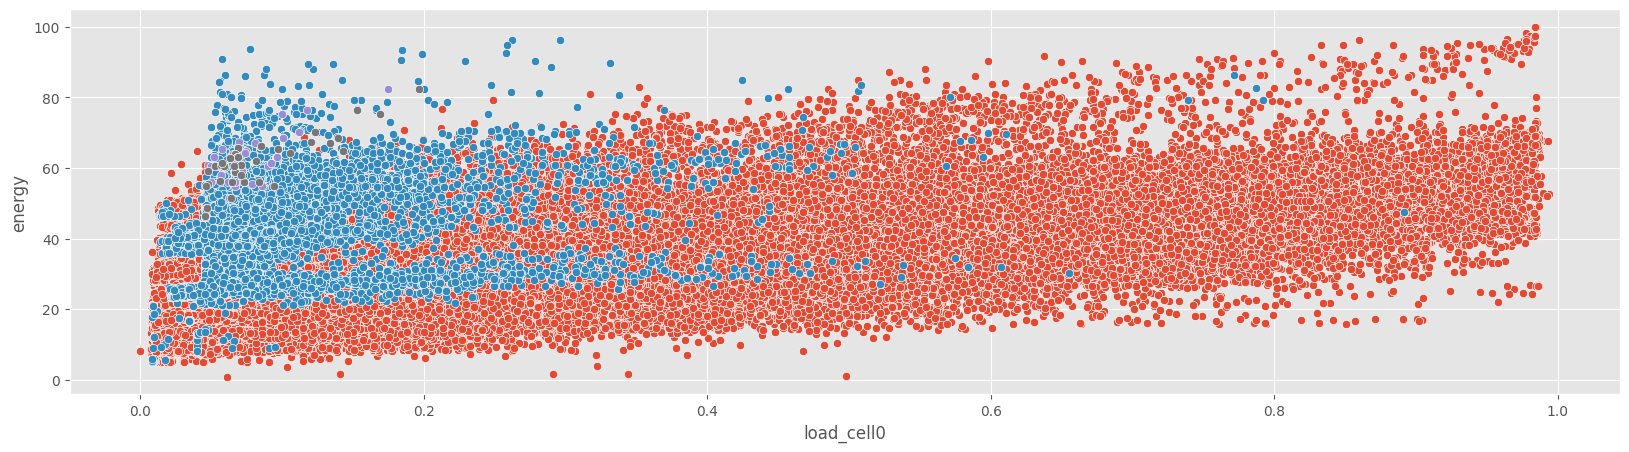

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell3', y='energy')
plt.show()

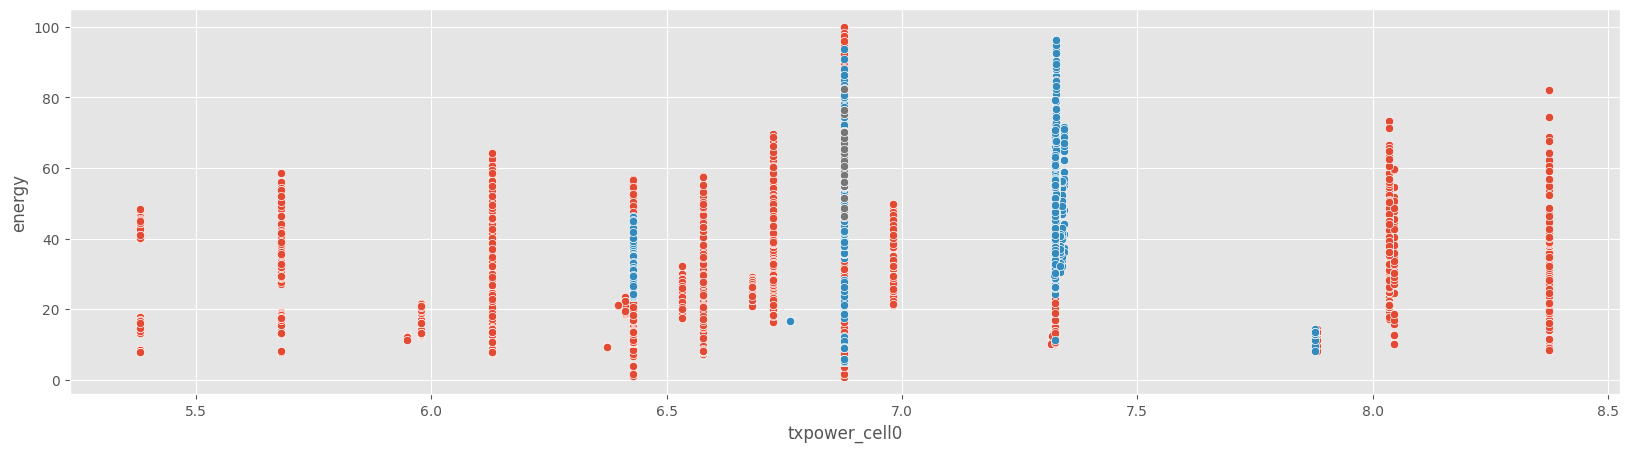

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell3', y='energy')
plt.show()

## Modeling

In [ ]:
train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

((92629, 50), (26139, 50))

In [ ]:
def feature_engineering(data):
    # Time-based features
    data['hour'] = data['time'].dt.hour
    data['dayofweek'] = data['time'].dt.dayofweek
    data['month'] = data['time'].dt.month
    data['dayofyear'] = data['time'].dt.dayofyear
    data['weekofyear'] = data['time'].dt.isocalendar().week
    data['is_weekend'] = data['dayofweek'].isin([5, 6]).astype(int) # 5 and 6 represent Saturday and Sunday

    # Lagged features (example: lag of 1 hour)
    data['load_cell0_lag1'] = data.groupby('bs')['load_cell0'].shift(1)
    data['load_cell1_lag1'] = data.groupby('bs')['load_cell1'].shift(1)
    data['load_cell2_lag1'] = data.groupby('bs')['load_cell2'].shift(1)
    data['load_cell3_lag1'] = data.groupby('bs')['load_cell3'].shift(1)
    # ... (Add lags for other relevant features and time periods as needed)

    # Rolling statistics (example: rolling mean of load_cell0 over 3 hours)
    data['load_cell0_rolling_mean3'] = data.groupby('bs')['load_cell0'].transform(lambda x: x.rolling(3).mean())
    data['load_cell1_rolling_mean3'] = data.groupby('bs')['load_cell1'].transform(lambda x: x.rolling(3).mean())
    data['load_cell2_rolling_mean3'] = data.groupby('bs')['load_cell2'].transform(lambda x: x.rolling(3).mean())
    data['load_cell3_rolling_mean3'] = data.groupby('bs')['load_cell3'].transform(lambda x: x.rolling(3).mean())
    # ... (Add other rolling statistics for relevant features and window sizes as needed)

    # Interaction features (example: interaction between load_cell0 and txpower_cell0)
    data['load_txpower_interaction'] = data['load_cell0'] * data['txpower_cell0']
    # ... (Add other interactions as you see fit)

    # One-hot encoding for categorical features
    data = pd.get_dummies(data, columns=['rutype', 'mode'], drop_first=True)
    # (Assuming 'rutype', 'mode' are the relevant categorical features)
    # Convert 'time' column to datetime if not already



    return data

In [ ]:
target_col = 'energy'
drop_cols = ['time', 'bs', 'split', target_col]

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Perform K-Fold cross-validation with 5 splits
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
kf = kf.split(X=train_data)

oof_valid_preds = np.zeros(train_data.shape[0])
test_preds_list = []

for i, (train_idx, valid_idx) in enumerate(kf):
    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    # Drop columns that should not be used in training
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    # Define columns for numeric and non-numeric data
    numeric_cols = train_df[train_cols].select_dtypes(include=['float64', 'int64']).columns.tolist()
    non_numeric_cols = train_df[train_cols].select_dtypes(exclude=['float64', 'int64']).columns.tolist()

    # Pipeline for processing
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numeric_cols),  # Impute numeric columns
            ('cat', OneHotEncoder(handle_unknown='ignore'), non_numeric_cols)  # One-hot encode categorical columns
        ]
    )

    # Fit and transform the data using preprocessor pipeline
    X_train = preprocessor.fit_transform(train_df[train_cols])
    X_valid = preprocessor.transform(valid_df[train_cols])
    X_test = preprocessor.transform(test_df[train_cols])

    y_train = train_df[target_col]
    y_valid = valid_df[target_col]

    # Define parameters for the LightGBM model
    params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'max_depth': -1,
        'metric': 'mae',
        'num_boost_round': 10000,
    }

    model = lgb.LGBMRegressor(**params)

    early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
    verbose_callback = lgb.log_evaluation(100)

    # Train the model with early stopping and logging
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[early_stopping_callback, verbose_callback],
    )

    # Store predictions
    oof_valid_preds[valid_idx] = model.predict(X_valid)
    test_preds_list.append(model.predict(X_test))


[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008644 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1603
[LightGBM] [Info] Number of data points in the train set: 74103, number of used features: 28
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Start training from score 28.166201
[100]	valid_0's l1: 2.83973
[200]	valid_0's l1: 2.82184
[300]	valid_0's l1: 2.8184
[LightGBM] [Warning] num_iterations is set=10000, num_boost_round=10000 will be ignored. Current value: num_iterations=10000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009492 seconds.
You can set `force_row_wise=tru

In [ ]:
test_preds_list

[array([16.12473555, 47.23794588, 19.45305214, ..., 20.41429828,
        23.90974269, 35.95218718]),
 array([16.03014699, 48.4879579 , 19.71557142, ..., 20.25993215,
        23.91186313, 35.86352005]),
 array([16.11589594, 46.35084065, 19.59880497, ..., 20.14872054,
        23.8724013 , 35.94994458]),
 array([16.09512273, 47.7060992 , 19.84562797, ..., 20.35925109,
        24.09653314, 35.58173524]),
 array([16.125516  , 48.44827346, 19.1667985 , ..., 20.22950937,
        23.94165992, 35.96876985])]

In [ ]:
test_preds_mean = np.mean(test_preds_list, axis=0)

In [ ]:
test_preds_mean

array([16.09828344, 47.64622342, 19.555971  , ..., 20.28234228,
       23.94644003, 35.86323138])

In [ ]:
test_preds_mean.shape

(26139,)

In [ ]:
test_data.shape

(26139, 50)

In [ ]:
test_data['Energy'] = test_preds_mean

<Axes: >

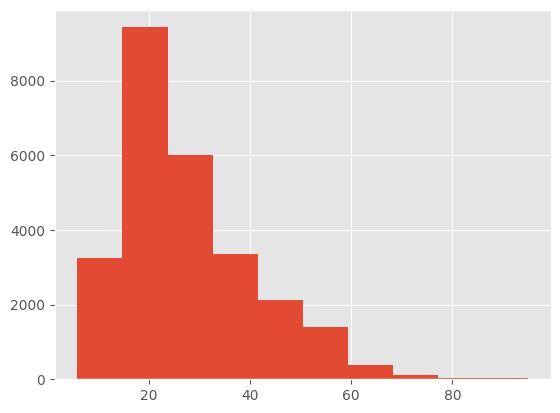

In [ ]:
test_data['Energy'].hist()

In [ ]:
ss_df.head()

,ID,Energy
0,2023-01-01 06:00:00_B_0,0
1,2023-01-01 11:00:00_B_0,0
2,2023-01-01 12:00:00_B_0,0
3,2023-01-01 13:00:00_B_0,0
4,2023-01-01 23:00:00_B_0,0


In [ ]:
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

In [ ]:
test_data[['ID', 'Energy']]

,ID,Energy
3,2023-01-01 01:00:00_B_100,16.098283
8,2023-01-01 01:00:00_B_105,47.646223
10,2023-01-01 01:00:00_B_107,19.555971
15,2023-01-01 01:00:00_B_111,41.632533
18,2023-01-01 01:00:00_B_114,24.213412
...,...,...
118757,2023-01-08 00:00:00_B_786,27.293206
118761,2023-01-08 00:00:00_B_790,23.221190
118762,2023-01-08 00:00:00_B_791,20.282342
118763,2023-01-08 00:00:00_B_792,23.946440


In [ ]:
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [ ]:
ss_df.head()

,ID,Energy
0,2023-01-01 06:00:00_B_0,54.374861
1,2023-01-01 11:00:00_B_0,67.648097
2,2023-01-01 12:00:00_B_0,65.620005
3,2023-01-01 13:00:00_B_0,67.124841
4,2023-01-01 23:00:00_B_0,79.828945


In [ ]:
ss_df.to_csv("base_model_submission.csv", index=False)